In [1]:
import os
import gzip
import shutil
import requests

import numpy as np
import pandas as pd

import tensorflow as tf
from keras import Sequential, metrics
from keras.layers import Input, Dense, BatchNormalization, LSTM, Embedding, Bidirectional, Normalization, Conv1D, Dropout, MaxPool2D,MaxPooling1D, Flatten
from keras.models import Model

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA


In [2]:
VERBOSE=False
EPOCHS=25
TRAIN_SIZE=.75

METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

2022-02-28 13:41:02.658375: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## get the data

In [3]:

import gzip
import shutil

def download_resource(resource):
    url_dl_pattern = 'http://ctdbase.org/reports/{resource}.csv.gz'
    url = url_dl_pattern.format(resource=resource)
    
    print('downloading: {0}'.format(resource))
    local_filename = 'zipped_data/' + url.split('/')[-1]
    unzipped_filename = 'unzipped_data/' + url.split('/')[-1].replace('.gz', '')
    
    if os.path.isfile(unzipped_filename):
        print('data already exists')
        return 

    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)

    with gzip.open(local_filename, 'rb') as f_in:
        with open(unzipped_filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    return local_filename


resources = [
#     'CTD_chem_gene_ixn_types',
#     'CTD_chem_pathways_enriched',
#     'CTD_genes_diseases',
#     'CTD_genes_pathways',
#     'CTD_diseases_pathways',
#     'CTD_pheno_term_ixns',
#     'CTD_exposure_studies',
#     'CTD_chemicals',
#     'CTD_genes',
    'CTD_chem_gene_ixns',
    'CTD_chemicals_diseases',
    'CTD_diseases'
]

for res in resources:
    download_resource(res)


def get_df(resource):
    line_number = 27
    the_file = 'unzipped_data/{resource}.csv'.format(resource=resource)
    with open(the_file, 'r') as reader:
        for i, row in enumerate(reader):
            if i == line_number:
                header = row.replace('# ', '').split(',')

    # print(header)
    df = pd.read_csv(the_file, skiprows=29, names=header)
    return df

downloading: CTD_chem_gene_ixns
data already exists
downloading: CTD_chemicals_diseases
data already exists
downloading: CTD_diseases
data already exists


In [48]:
class DiseaseClassifier:
    def __init__(self, input_df, parent_disease, gene_count, show_plots, use_class_weights, oversample, model_type, classification='binary'):
        self.input_df = input_df
        self.parent_disease = parent_disease
        self.target_diseases = self.get_diseases()
        self.gene_count = gene_count
        self.show_plots = show_plots
        self.stop_early = True
        self.use_class_weights = use_class_weights
        self.oversample = oversample
        self.model_type = model_type
        self.classification = classification
        self.top_n_genes = self.get_genes()

        if self.use_class_weights and self.oversample:
            raise Exception('Need to either use classweights OR oversample')
        
    def get_diseases(self):
        
        disease_df = get_df('CTD_diseases')
        disease_df['ParentIDs'].str.split('|').explode()

        hierarchy_df = disease_df\
            .assign(ParentIDs=disease_df['ParentIDs'].str.split('|')).explode('ParentIDs')

        # top_of_tree = 'MESH:D010300' # parkinsons disease
        # top_of_tree = 'MESH:D020734' # Parkinsonian Disorders
        # top_of_tree = 'MESH:D019636' # neurodegenerative diseases
        # top_of_tree = 'MESH:D009422' # nervous system diseases
        top_of_tree = self.parent_disease
        level_one = hierarchy_df.loc[hierarchy_df['ParentIDs'] == top_of_tree]
        level_two = hierarchy_df.loc[hierarchy_df['ParentIDs'].isin(level_one['DiseaseID'])]
        level_three = hierarchy_df.loc[hierarchy_df['ParentIDs'].isin(level_two['DiseaseID'])]

        # to do, do this recursively..
        all_diseases = list(level_one['DiseaseID'].unique()) \
                     + list(level_two['DiseaseID'].unique()) \
                     + list(level_three['DiseaseID'].unique()) \
                     + [top_of_tree]

        return all_diseases
    
    def get_genes(self):
        gene_df = pd.DataFrame(self.input_df.groupby(['InferenceGeneSymbol']).size()).reset_index()
        gene_df.columns = ['InferenceGeneSymbol','cnt']
        top_n_genes_df = gene_df.sort_values('cnt', ascending=False)[:self.gene_count]
        top_n_genes = top_n_genes_df['InferenceGeneSymbol'].unique()

        return top_n_genes
    
    def prep_training_data(self):
        
        gene_df = self.input_df.loc[self.input_df['DirectEvidence'].isnull()][['ChemicalName', 'DiseaseName', 'InferenceGeneSymbol', 'InferenceScore', 'DiseaseID']]

        gene_df = gene_df.loc[gene_df['InferenceGeneSymbol'].isin(self.top_n_genes)]

        evidence_df = self.input_df.loc[self.input_df['DirectEvidence'].notnull()][['ChemicalName', 'DiseaseName', 'DirectEvidence', 'DiseaseID']]
        merged_df = gene_df.merge(evidence_df, on=['ChemicalName', 'DiseaseName', 'DiseaseID'])

        dummy_df = pd.get_dummies(merged_df, prefix='', prefix_sep='',columns=['InferenceGeneSymbol'])
        gb_df = dummy_df.groupby(['DiseaseName', 'ChemicalName', 'DiseaseID']).agg({np.max}).reset_index()

        gb_df.columns = gb_df.columns.droplevel(1)

        gb_df['label'] = np.where(gb_df['DirectEvidence'] == 'marker/mechanism',
                                                   gb_df['InferenceScore'] * -1,
                                                   gb_df['InferenceScore'])
        
        return gb_df
    
    def plot_results(self, history, predicted_values, y_test, accuracy):

        auc_score = roc_auc_score(y_test, predicted_values) 

        if self.show_plots:
            # plot accuracy
            fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
            axes[0][0].plot(history.history['accuracy'],label='accuracy')
            axes[0][0].plot(history.history['val_accuracy'],label='val_accuracy')
            axes[0][0].text(2, history.history['accuracy'][0] + .005, 'accuracy: {:.4f}'.format(accuracy))

            axes[0][0].legend()

            # plot loss
            axes[0][1].plot(history.history['loss'],label='loss')
            axes[0][1].plot(history.history['val_loss'],label='val_loss')
            axes[0][1].legend()
            fig.tight_layout()

            fpr, tpr, thresholds = roc_curve (y_test , predicted_values)

            # plot_roc_curve
            axes[1][0].plot(fpr,tpr)
            axes[1][0].text(0.7, 0.9, 'auc: {:.4f}'.format(auc_score))
            axes[1][0].axis([-.05,1.1,0,1.05]) 

            # plot confusion matrix
            cm = confusion_matrix(y_test, np.where(predicted_values > 0.5, 1, 0))

            labels = ["Non Target", "Target"]
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

            disp.plot(cmap=plt.cm.Blues, ax=axes[1][1]) # xticks_rotation=45

        return auc_score
    
    def get_class_weights(self, labels):
        """
        To Do - make this dynamic to deal with N classes
        """
        neg, pos = np.bincount(labels)
        total = neg + pos

        # Scaling by total/2 helps keep the loss to a similar magnitude.
        # The sum of the weights of all examples stays the same.
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)

        class_weight = {0: weight_for_0, 1: weight_for_1}

        # print('Weight for class 0: {:.2f}'.format(weight_for_0))
        # print('Weight for class 1: {:.2f}'.format(weight_for_1))
        
        return class_weight
    
    def get_model(self, input_shape):
        model = Sequential()
            
        if self.model_type == 'CNN':
            model.add(Conv1D(64, 2, activation="relu", input_shape=(input_shape,1)))
            model.add(Dense(16, activation="relu"))
            model.add(MaxPooling1D())
            model.add(Flatten())
            model.add(Dense(1, activation = 'sigmoid'))
        else:
            model.add(Dense(60, input_dim=input_shape, activation='relu'))
            model.add(Dense(6, input_dim=input_shape, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))

        model.compile(loss=self.classification + '_crossentropy', optimizer='adam', metrics=METRICS)
        return model
    
    def over_sample(self, X_train, y_train):
        if self.classification = 'categorical':
            raise Exception('over sampling not supported with categorical classifications')
        bool_train_labels = y_train != 0

        pos_features = X_train[bool_train_labels]
        neg_features = X_train[~bool_train_labels]

        pos_labels = y_train[bool_train_labels]
        neg_labels = y_train[~bool_train_labels]

        ids = np.arange(len(pos_features))
        choices = np.random.choice(ids, len(neg_features))

        res_pos_features = pos_features.iloc[choices, :]
        res_pos_labels = pos_labels.values[choices] # pos_labels.array(choices)

        res_pos_features.shape

        resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
        resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

        order = np.arange(len(resampled_labels))
        np.random.shuffle(order)
        resampled_features = resampled_features[order]
        resampled_labels = resampled_labels[order]

        return resampled_features, resampled_labels
        
    def train_model(self, train_df):

        gene_columns = train_df.columns.intersection(self.top_n_genes)
        shuffled_df = train_df.sample(frac=1)
        features, labels = shuffled_df[gene_columns], shuffled_df['binary_label']
        
        model = self.get_model(features.shape[1])
        
        X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=TRAIN_SIZE)
        
        if self.oversample:
            X_train, y_train = self.over_sample(X_train, y_train)
        
        callbacks = []
        if self.stop_early:
            callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2))

        model_fit_kw = {
            'x': X_train,
            'y': y_train,
            'epochs':25,
            'validation_split':0.2,
            'callbacks':callbacks,
            'verbose':VERBOSE
        }
        if self.use_class_weights:
            model_fit_kw['class_weight'] = self.get_class_weights(labels)
        
        ## fit the model
        history = model.fit(**model_fit_kw)
        
        ## make predictions on the test set
        predicted_values = model.predict(X_test)

        model_metrics = model.evaluate(X_test, y_test, verbose=VERBOSE)
        model_keys = ['loss'] + [m.name for m in METRICS]
        metrics_info = dict(zip(model_keys, model_metrics))

        auc = self.plot_results(history, predicted_values, y_test, metrics_info.get('accuracy'))

        
        return history,model, auc, metrics_info

    
    def set_label(self, train_df):

        target_diseases = self.get_diseases()
        train_df['binary_label'] = np.where(train_df['DiseaseID'].isin(target_diseases),1, 0)
        
        return train_df
        
   
    def main(self):
        train_df = self.prep_training_data()
        train_df = self.set_label(train_df)
        history, model, auc, model_metrics =  self.train_model(train_df)

        model_metrics['parent_disease'] = self.parent_disease
        model_metrics['gene_count'] = self.gene_count
        model_metrics['show_plots'] = self.show_plots
        model_metrics['use_class_weights'] = self.use_class_weights
        model_metrics['oversample'] = self.oversample
        model_metrics['model_type'] = self.model_type
               
        
        return model_metrics
        # print(model_metrics)
        
        


In [ ]:
input_df = get_df('CTD_chemicals_diseases')

In [62]:
def get_class_weights(labels):
    """
    To Do - make this dynamic to deal with N classes
    """
    neg, pos = np.bincount(labels)
    total = len(labels) + 10

    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same.
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))

    return class_weight

input_df['binary_label'] = np.where(input_df['DiseaseID'].isin(['MESH:D000230']),1, 0)
# input_df[:4]
actual = get_class_weights(input_df['binary_label'])
target = {0: 0.5026681234122876, 1: 94.1988142484965}
assert(actual == target)

Weight for class 0: 0.50
Weight for class 1: 94.20


AssertionError: 

## DNN with class weights

In [ ]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 1000,
    'model_type':'DNN',
    'show_plots': True,
    'use_class_weights': True,
    'oversample': False
}
dc = DiseaseClassifier(**kw)
dc_mm = dc.main()
display(pd.DataFrame([mm]))

## CNN with class weights

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,0.194549,111.0,1157.0,11660.0,20.0,0.909098,0.087539,0.847328,0.965196,0.464002


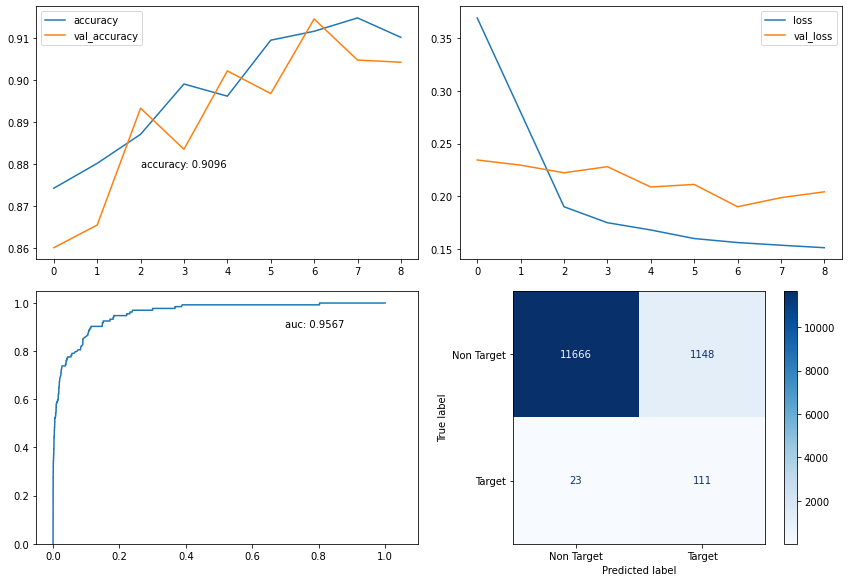

In [36]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 1000,
    'model_type':'CNN',
    'show_plots': True,
    'use_class_weights': True,
    'oversample': False
}
cnn_dc = DiseaseClassifier(**kw)
cnn_dc_mm = cnn_dc.main()
display(pd.DataFrame([mm]))

## DNN with Oversampling

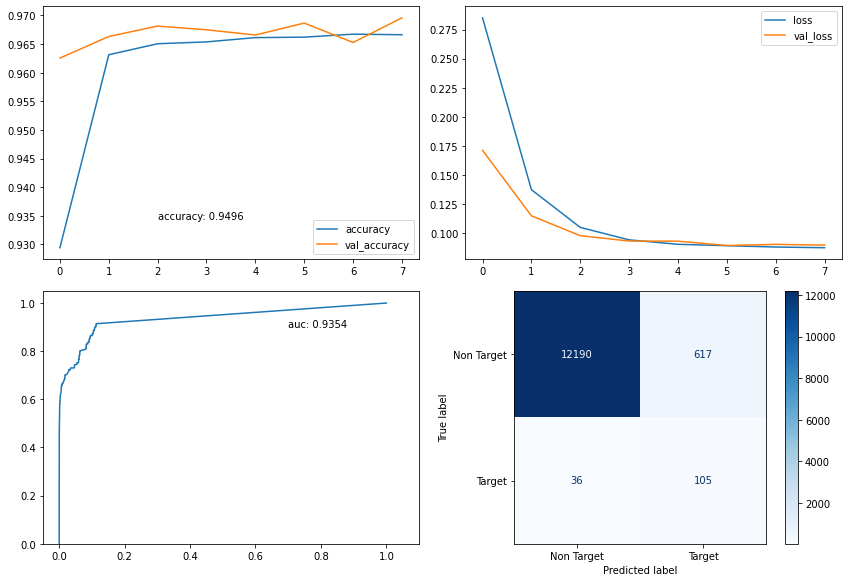

In [37]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 1000,
    'model_type':'DNN',
    'show_plots': True,
    'use_class_weights': False,
    'oversample': True
}
dnn_os = DiseaseClassifier(**kw)
mm = dnn_os.main()

## Iterate over a number of different permutations 

In [50]:
import time
import json
import datetime
from itertools import product

params = {
    'gene_count': [20, 50, 100, 250, 500, 1000, 2000, 3000, 5000],
    'parent_disease': ['MESH:D019636'],
    'model_type': ['CNN', 'DNN'],
    'use_class_weights': [True, False],
    'oversample': [True, False]
}


permutations = [dict(zip(params, v)) for v in product(*params.values())]

# permutations = dnn_permutations + lstm_permutations

print('-- len permutations ---')
print('we have', len(permutations))

results = []

for i, (p) in enumerate(permutations):
    p['input_df'] = input_df
    p['show_plots'] = False
    try:
        _m = DiseaseClassifier(**p)
    except Exception:
        continue
    
    model_results = _m.main()
    with open('out_stream.txt', 'a') as f:
        f.write(json.dumps(model_results) + '\n')
    results.append(model_results)

df = pd.DataFrame(results)

now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
df.to_csv('final-output/{ts}.csv'.format(ts=now))
display(df.sort_values('recall', ascending=False)[:10])

-- len permutations ---
we have 72


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,parent_disease,gene_count,show_plots,use_class_weights,oversample,model_type
0,0.369441,82.0,1604.0,6468.0,12.0,0.802106,0.048636,0.872340,0.922559,0.330265,MESH:D019636,20,False,True,False,CNN
1,0.279733,75.0,1071.0,7005.0,15.0,0.867010,0.065445,0.833333,0.938009,0.322241,MESH:D019636,20,False,False,True,CNN
2,0.040274,19.0,9.0,8070.0,68.0,0.990571,0.678571,0.218391,0.884307,0.363164,MESH:D019636,20,False,False,False,CNN
3,0.262770,87.0,1085.0,6980.0,14.0,0.865418,0.074232,0.861386,0.938391,0.600781,MESH:D019636,20,False,True,False,DNN
4,0.299354,88.0,1180.0,6886.0,12.0,0.854029,0.069401,0.880000,0.944077,0.626905,MESH:D019636,20,False,False,True,DNN
5,0.028987,32.0,7.0,8073.0,54.0,0.992530,0.820513,0.372093,0.938662,0.537300,MESH:D019636,20,False,False,False,DNN
6,0.377660,94.0,2305.0,7509.0,11.0,0.766509,0.039183,0.895238,0.939280,0.439189,MESH:D019636,50,False,True,False,CNN
7,0.297765,87.0,1444.0,8377.0,11.0,0.853312,0.056826,0.887755,0.953417,0.352422,MESH:D019636,50,False,False,True,CNN
8,0.033772,44.0,7.0,9805.0,63.0,0.992943,0.862745,0.411215,0.903644,0.514584,MESH:D019636,50,False,False,False,CNN
9,0.222923,79.0,1115.0,8713.0,12.0,0.886380,0.066164,0.868132,0.957946,0.596871,MESH:D019636,50,False,True,False,DNN


##  DNN with Multi Class

In [ ]:
# do this

## Analyze "Marker Mechanism" / Therapeutic Chemicals

In [ ]:
## do this

## Gene Importance for Neurodegenrative

In [ ]:
## do this

## Gene Importance for Parkinsons

In [ ]:
## di tgus

In [ ]:
## Future Work 
- use the random forest gene importance to better select the features
- PCA
- regression model for predicting inference score